## Генераторы случайных чисел

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Желаемые свойства ГСЧ:
* моделирует равномерное распределение на [0, 1]
* проходит статистические тесты (какие?)
* высокая скорость работы
* большой период
* может работать на любом вычислительном устройстве
* воспроизводимость (а как же случайность?)
* криптографическая устойчивость (это не противоречит предыдущим требованиям?)

Генератор псевдослучайных чисел - это __алгоритм__ (!!!), который проходит статистические тесты.

### Middle-square algorithm
John von Neumann, 1949

Идея:
1. задаем четырехзначный seed - первое число случайной последовательности
2. возводим в квадрат, получаем 8-ми значное число (при необходимости, дополняем нулями)
3. берем четырехзначное число из середины - это следующий элемент случайной последовательности
4. повторяем 2-3

In [3]:
import numpy as np

def midsquare(val, n=4):
    return int(str(val**2).zfill(2*n)[n//2:-n//2])

seed = 5497
seq = [seed]
for _ in range(100):
    seq.append(midsquare(seq[-1]))
np.array(seq)

array([5497, 2170, 7089, 2539, 4465, 9362, 6470, 8609, 1148, 3179, 1060,
       1236, 5276, 8361, 9063, 1379, 9016, 2882, 3059, 3574, 7734, 8147,
       3736, 9576, 6997, 9580, 7764, 2796, 8176, 8469, 7239, 4031, 2489,
       1951, 8064,  280,  784, 6146, 7733, 7992, 8720,  384, 1474, 1726,
       9790, 8441, 2504, 2700, 2900, 4100, 8100, 6100, 2100, 4100, 8100,
       6100, 2100, 4100, 8100, 6100, 2100, 4100, 8100, 6100, 2100, 4100,
       8100, 6100, 2100, 4100, 8100, 6100, 2100, 4100, 8100, 6100, 2100,
       4100, 8100, 6100, 2100, 4100, 8100, 6100, 2100, 4100, 8100, 6100,
       2100, 4100, 8100, 6100, 2100, 4100, 8100, 6100, 2100, 4100, 8100,
       6100, 2100])

Может быть усложним алгоритм, добавив еще несколько операций?

```
… random numbers should not be
generated with a method chosen at
random. Some theory should be
used.
```
D. Knuth

### Linear congruential generator (LCG)

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG (на практике чуть сложнее):

In [16]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [6]:
[rng() for _ in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Как проверить, что последовательность действительно похожа на выборку из равномерного распределения?

Сделаем выборку побольше

In [17]:
samples = [rng() for _ in range(1000)]

В качестве первого шага построим гистограмму

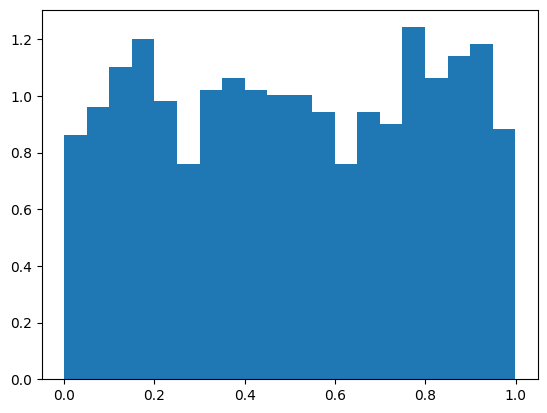

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.hist(samples, bins=20, density=True)
plt.show()

На вид гистограммма не противоречит гипотезе о равномерности распределения, но нужны более точные количественные оценки. Их получают с помощью статистических тестов.

###Статистические тесты

Общая идея статистических тестов. Пусть мы хотим проверить гипотезу о том, что выборка Х принадлежит некоторому конкретному (совершенно конкретному) распределению F. Задача состоит в том, чтобы придумать такую статистику (функцию от выборки) T(X), которая в случае истинности нашей гипотезы будет иметь (при $n\to\infty$) наперед известное распределение, например N(0, 1). Посчитаем значение статистики Т=Т(Х) на нашей выборке. Если полученное число Т окажется крайне нетипичным для нормального N(0, 1) распределения, отвергнем гипотезу. Более точно, вычислим $p=P(|\xi|\ge|T|)$ для $\xi\sim N(0,1)$. Это число $p$ имеет специальное название: $p$-value. Если оно маленькое, например, меньше 0.05, то это повод отвергнуть гипотезу.

Далее обсудим конкретные тесты.


### Kolmogorov-Smirnov test

Проверяем гипотезу, что выборка получена из распределения F.
Вычисляем статистику
$$T(X) = \sup_x| F(x) - F_n(x)|,$$
где $F_n(x)$ - эмпирическая функция распределения, построенная по выборке Х объема n.
По сути, Т - это наибольшее расстояние между двумя графиками (см. картинку ниже).

Оказывается, что в случае истинности гипотезы, величина $ \sqrt{n}T$ имеет (в пределе больших n) особое распределение, которое называется [распределением Колмогорова](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%9A%D0%BE%D0%BB%D0%BC%D0%BE%D0%B3%D0%BE%D1%80%D0%BE%D0%B2%D0%B0).

Распределение Колмогорова является табличным, поэтому для любого значения статистики Т мы можем найти $p$-value и увидеть, будет оно маленьким или нет.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/KS_Example.png/450px-KS_Example.png)

На практике все делается одной строкой (проверяет гипотезу о принадлежности выбоки равномерному распределению ```stats.uniform.cdf```):

In [ ]:
from scipy import stats

stats.kstest(samples, stats.uniform.cdf)

KstestResult(statistic=0.026368738710880302, pvalue=0.4892115759774217)

Как интерпретировать результаты?

statistic=0.02636 - значение статистики (максимальное расстояние между графиками)

pvalue=0.48921 - pvalue для этого значения статистики. Видим, что pvalue > 0.05, так что мы решаем НЕ отвергать гипотезу о равномерном распределении.

Для сравнения, проверим гипотезу, что выборка порождена нормальным законом:

In [ ]:
stats.kstest(samples, stats.norm.cdf)

KstestResult(statistic=0.500866322716208, pvalue=1.4724733582412854e-232)

Здесь pvalue крайне маленькое, и мы смело отвергаем гипотезу.

### Chi-squared test (Pearson's chi-squared test)

Один из самых популярных тестов. Снова проверяем гипотезу, что выборка (объема n) пришла из распределения F. Идея в том, чтобы разбить всю область определения случайной величины на К интервалов и в каждом интервале посчитать, сколько элементов выборки попало в данный интервал и сколько мы бы ожидали там увидеть, если бы выборка имела размер n и порождалась распределением F. Составляем статистику
$$\chi^2_{K-1}=\sum\limits_{i=1}^{K}\frac{(E_i-O_i)^2}{E_i}$$

$E_i, O_i$ - ожидаемые (expected) и наблюдаемые (observed) количества элементов выборки в i-ом интервале значений.

Рекомендуется выбирать K таким, чтобы $O_i, E_i \ge 5$.

Если гипотеза верна, то статистика критерия имеет (в пределе больших n) распределение хи-квадрат с К-1 степенью свободы.

Пример применения теста хи-квадрат:

In [ ]:
k = 20
f_obs = np.histogram(samples, np.linspace(0, 1, k+1))[0]
f_exp = np.full(k, len(samples) // k)

f_obs, f_exp, stats.chisquare(f_obs, f_exp)

(array([42, 49, 55, 60, 49, 38, 51, 53, 51, 50, 50, 47, 38, 47, 45, 65, 50,
        60, 56, 44], dtype=int64),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50]),
 Power_divergenceResult(statistic=18.599999999999998, pvalue=0.48275240319942647))

Вывод - наблюдаемое значение статистики не противоречит гипотезе о равномерном распределении.

Проблема: последовательности ```sorted(samples)``` и ```samples``` неразличимы для KS и Chi2 тестов. Нужны дополнительные тесты.


### Serial test

Идея: разбить последовательность $x_1, x_2, x_3, ..., x_{2n}$ на последовательные серии длины 2: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ и посмотреть на каждый элемент как на случайную и независимую точку в 2D пространстве. Далее применить хи-квадрат. Аналогично, можно строить серии длины 3, 4 и т.д.

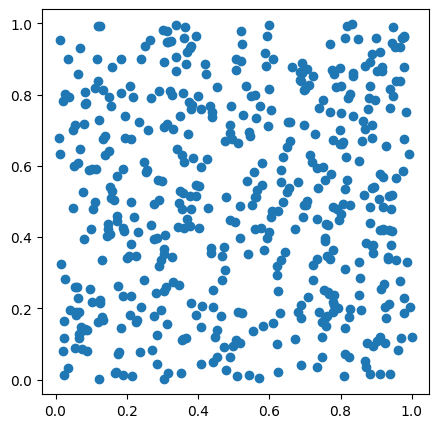

In [18]:
fig = plt.figure(figsize=(5, 5))
fig.patch.set_facecolor('xkcd:white')

plt.scatter(samples[::2], samples[1::2])
plt.axis('equal')
plt.show()

### Задача 1*
Реализовать serial test и применить к выборке samples

### Permutation test

Снова разобъем последовательность $x_1, x_2, x_3, ..., x_{dn}$ на последовательные серии длины d: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), ..., (x_{nd-d}, x_{nd})$. Серия из d элементов может быть упорядочена d! способами и каждый способ упорядочивания равновероятен. Отсюда идея теста - посчитать, сколько раз каждый порядок встречается среди n серий и применить хи-квадрат тест.

### Задача 2*
Реализовать permutation test и применить к выборке samples

In [ ]:
#code here

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать неудачно, это может привести к неожиданным последствиям:

In [ ]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

random = [rng_bad() for _ in range(30000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[3.051897510886192e-05,
 0.00018310965970158577,
 0.0008239871822297573,
 0.003295936156064272,
 0.012359732296317816,
 0.04449496837332845,
 0.15573221957311034,
 0.533938602078706,
 0.8020416363142431,
 0.006802399177104235]

Гистограмма распределения похожа на равномерное:

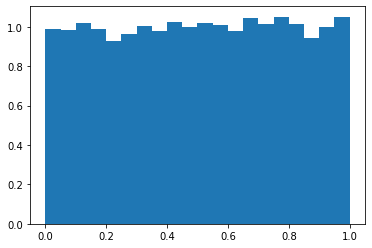

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')

plt.hist(random, 20, density=True)
plt.show()

Однако, тест серий показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с представлением о случайности:

<IPython.core.display.Javascript object>


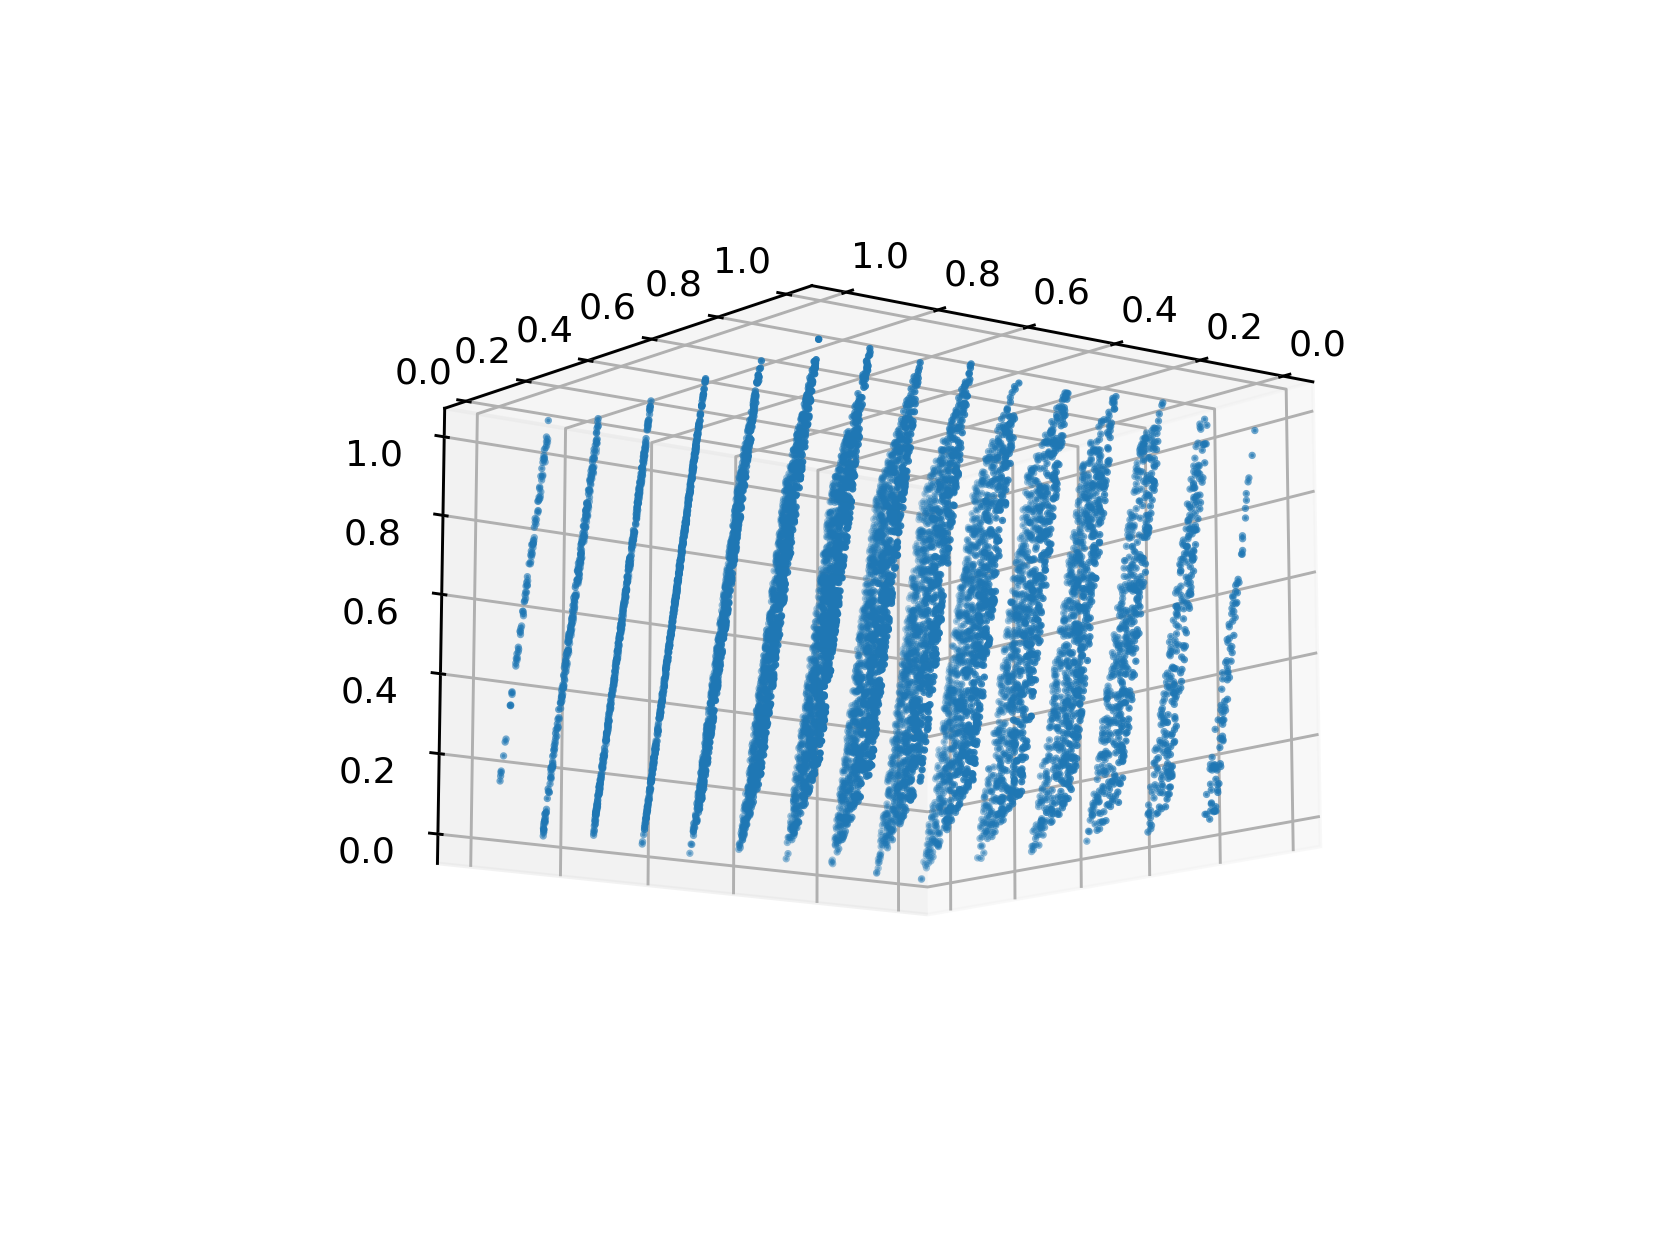

In [ ]:
import matplotlib
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(random[::3], random[1::3], random[2::3], s=1)
plt.show()

### Задача 3*

Привести статистический тест, который покажет, что с rng_bad есть проблемы, а с rng - нет.

In [ ]:
#code here

Больше тестов на случайность - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации равномерной величины [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

Сюжет про динамические системы и переход к хаосу https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1] (используйте для этого функцию `np.random.rand()`). Как получить выборку из другого распределения $F$?



### Задача 4
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса.

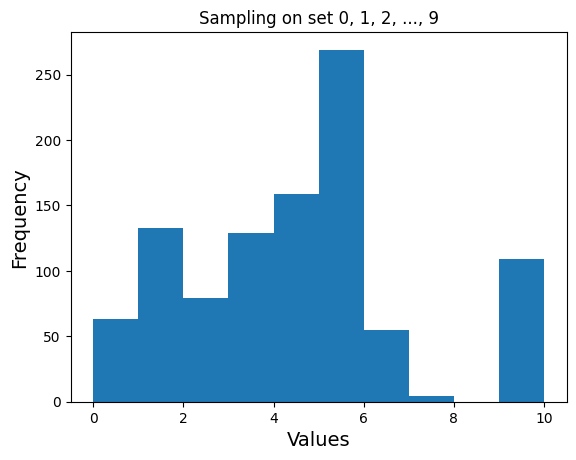

In [127]:
import numpy as np
import matplotlib.pyplot as plt

weights=np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
weights=weights/np.sum(weights)
a=np.zeros(1000)
for i in range(1000):
    r=np.random.rand()
    for k, j in enumerate(np.cumsum(weights)):
        if r<=j:
            a[i]=k
            break

plt.hist(a, np.arange(11))
plt.xlabel("Values", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Sampling on set 0, 1, 2, ..., 9")
plt.show()

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача 5
Смоделируйте выборку размера 1000 из распределения $Exp(\lambda)$ с помощью метода Inverse transform. Постройте выборочную гистограмму и точный график плотности распределения.

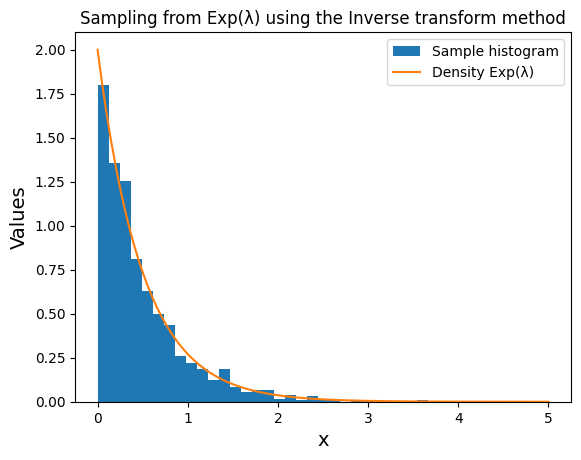

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

lambd=2
a=[-np.log(1-np.random.rand(1000))/lambd]

plt.hist(a, 30, density=True, label='Sample histogram')
plt.plot(np.linspace(0, 5, 100), expon.pdf(np.linspace(0, 5, 100), scale=1/lambd), label='Density Exp(λ)')
plt.xlabel('x', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Sampling from Exp(λ) using the Inverse transform method')
plt.legend()
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Более точно: пусть умеем моделировать выборку из распределения с плотностью $p$, а хотим получить выборку из распределения с плотностью $\pi$. Возьмем случайный $x$ из распределения $p$. Затем возьмем $y$, равномерно распределенный на интервале $[0, p(x)]$. Если точка $(x, y)$ попала под график $\pi$, то примем $x$ за элемент выборки из $\pi$. Если нет - повторяем процедуру для нового $x$. Картинка иллюстрирует идею метода (плотности нормируются так, чтобы одна лежала целиком под другой):
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>


### Задача 6
Обоснуйте (устно), что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из распределения с плотностью $e^xcos^2x$ на отрезке $[-\pi/2, \pi/2]$. По выборке постройте график выборочной гистограммы и сравните его с графиком точной функции плотности.

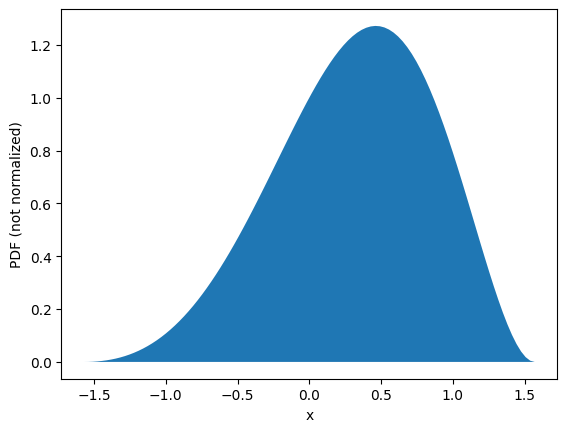

In [93]:
%matplotlib inline
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x)*np.cos(x)**2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.show()

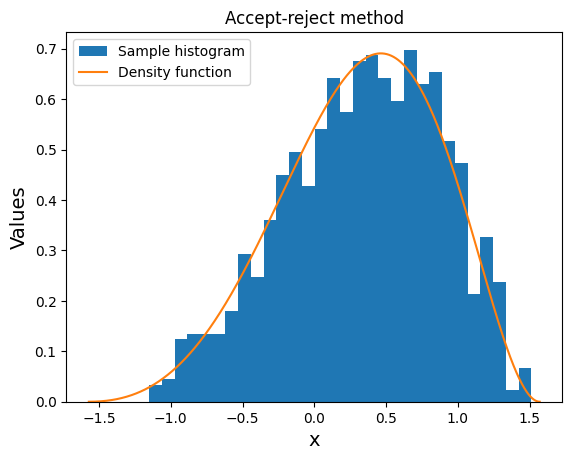

In [134]:
import numpy as np
import matplotlib.pyplot as plt

a=[]
while len(a)<1000:
    x=(np.random.rand()-0.5)*np.pi
    y=np.random.rand()
    if y<=np.exp(x)*np.cos(x)**2/np.trapz(np.exp((np.linspace(-np.pi/2, np.pi/2, 1000)))*np.cos(np.linspace(-np.pi/2, np.pi/2, 1000))**2, np.linspace(-np.pi/2, np.pi/2, 1000)):
        a.append(x)

plt.hist(a, 30, density=True, label='Sample histogram')
plt.plot(np.linspace(-np.pi/2, np.pi/2, 1000), np.exp(np.linspace(-np.pi/2, np.pi/2, 1000))*np.cos(np.linspace(-np.pi/2, np.pi/2, 1000))**2/np.trapz(np.exp((np.linspace(-np.pi/2, np.pi/2, 1000)))*np.cos(np.linspace(-np.pi/2, np.pi/2, 1000))**2, np.linspace(-np.pi/2, np.pi/2, 1000)), label='Density function')
plt.xlabel('x', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Accept-reject method')
plt.legend()
plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей (зачем?).

### Задача 7
Смоделировать и изобразить выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора.

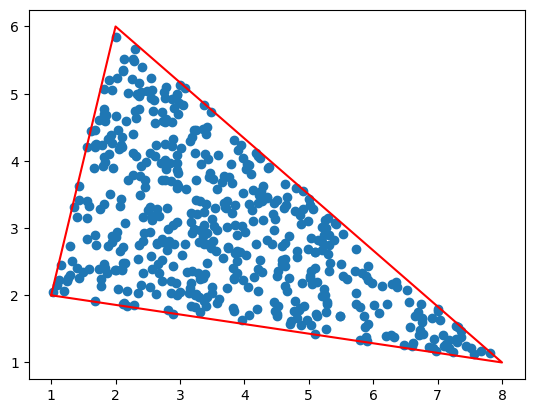

In [233]:
import numpy as np
import matplotlib.pyplot as plt

a=np.array([[1, 2], [2, 6], [8,1]])
b=np.zeros((500, 2))
for i in range(500):
  x=np.random.rand()
  y=np.random.rand()
  if (x+y>1):
    x=1-x
    y=1-y
  b[i]=a[0]+x*(a[1]-a[0])+y*(a[2]-a[0])

plt.scatter(b[:, 0], b[:, 1])
plt.plot([a[0][0], a[1][0], a[2][0], a[0][0]], [a[0][1], a[1][1], a[2][1], a[0][1]], 'r')
plt.show()

### Задача 8
Смоделировать без использования метода отбора выборку из 500 точек равномерно распределенных внутри единичного круга. Изобразите полученные точки. Они действительно равномерно заполняют круг?

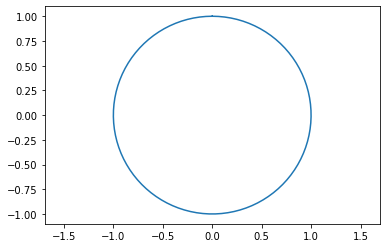

In [ ]:
%matplotlib inline
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')

t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

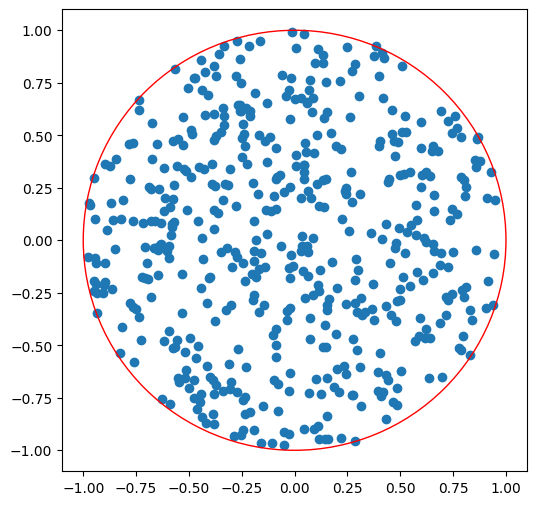

In [223]:
import numpy as np
import matplotlib.pyplot as plt

r=np.sqrt(np.random.rand(500))
fi=2*np.pi*np.random.rand(500)
x=r*np.cos(fi)
y=r*np.sin(fi)

plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.gca().add_patch(plt.Circle((0, 0), 1, color='r', fill=False))
plt.show()

## Random normal generator

### Задача 9
Докажите (устно), что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модифицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним [4, 7] и ковариационной матрицей [[20,  -4],
       [ -4, 40]]. Постройте 2D гистограмму полученного распределения. Сравните выборочное среднее и ковариационную матрицу с точными значениями.

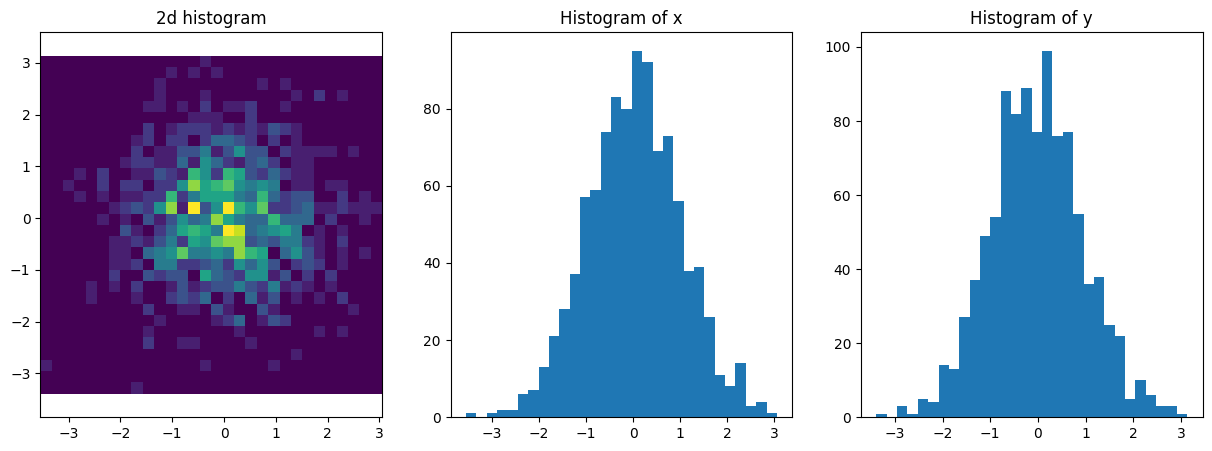

In [257]:
%matplotlib inline

n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('xkcd:white')
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

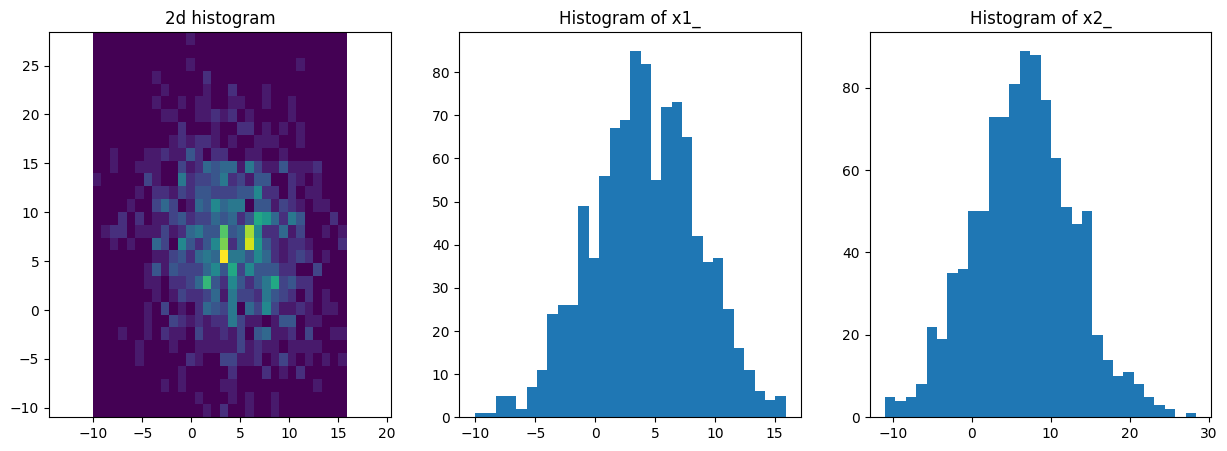

Sample mean: [ 4.140252455926616 , 6.604834312346627 ]


Covariance matrix:
[[19.75972659 -4.20944405]
 [-4.20944405 40.08770675]]


In [258]:
%matplotlib inline

n = 1000
u1, u2 = np.random.rand(2, n)*2-1
for i in range(n):
  while (u1[i]**2+u2[i]**2)>1:
    u1[i]=np.random.rand()*2-1
    u2[i]=np.random.rand()*2-1
s=u1**2+u2**2
s2=np.sqrt(-2*np.log(s)/s)
x1=s2*u1
x2=s2*u2
x1_=4+x1*(-2)+x2*4
x2_=7+x1*6+x2*2

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('xkcd:white')
ax[0].hist2d(x1_, x2_, bins=30)
ax[0].axis('equal')
ax[1].hist(x1_, bins=30)
ax[2].hist(x2_, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x1_")
ax[2].set_title("Histogram of x2_")
plt.show()

print("Sample mean: [", np.mean(x1_), ",", np.mean(x2_), "]")
print("\n")
print("Covariance matrix:")
print(np.cov(x1_, x2_))

### Задача 10*

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов.

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Solution here